## XGBoost model to detect merchants with Lowest Fraud Probability

In [9]:
! pip install xgboost

In [10]:
# Initialise a spark session
import pandas as pd
from collections import Counter
import os
from pyspark.sql import SparkSession
from pyspark.sql import functions as F


spark = (
    SparkSession.builder.appName("Fraud Detection")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "8g")  # Increase driver memory
    .config("spark.executor.memory", "8g")  # Increase executor memory
    .config("spark.executor.instances", "4")  # Increase the number of executor instances
    .config("spark.driver.maxResultSize", "2g")
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()
)

In [11]:
# Read transaction file
transactions = spark.read.parquet('../data/curated/flagged_fraud/*.parquet')

## Inspecting the structure

In [12]:
transactions.printSchema()

transactions.show(5)

root
 |-- merchant_abn: long (nullable = true)
 |-- year_week: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- consumer_id: long (nullable = true)
 |-- fraud_probability_consumer: double (nullable = true)
 |-- name_consumer: string (nullable = true)
 |-- address_consumer: string (nullable = true)
 |-- state_consumer: string (nullable = true)
 |-- postcode_consumer: integer (nullable = true)
 |-- gender_consumer: string (nullable = true)
 |-- name_merchant: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- fraud_probability_merchant: double (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- order_month_year: string (nullable = true)
 |-- SA4_CODE_2011: string (nullable = true)
 |-- SA4_NAME_2011: string (nullable = true)
 |-- unemployment_rate: string (nullable = true)
 |-- z_score: double (nullable = true)
 |-- consumer_weekly_transaction: long (nullabl

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pandas_df = transactions.select(
    "merchant_abn", "dollar_value", "fraud_probability_consumer", 
    "fraud_probability_merchant", "consumer_weekly_transaction", 
    "merchant_weekly_transaction", "z_score", "postcode_consumer", 
    "unemployment_rate", "is_fraud"
).toPandas()

print("Basic Statistics:")
print(pandas_df.describe(include="all"))

print("\nMissing Values Count:")
print(pandas_df.isnull().sum())

Basic Statistics:
        merchant_abn  dollar_value  fraud_probability_consumer  \
count   1.611599e+07  1.611599e+07                1.611599e+07   
unique           NaN           NaN                         NaN   
top              NaN           NaN                         NaN   
freq             NaN           NaN                         NaN   
mean    5.540170e+10  1.342180e+02                1.364578e+01   
std     2.532216e+10  2.052414e+02                8.600280e+00   
min     1.002328e+10  9.756658e-08                8.287144e+00   
25%     3.284414e+10  2.587279e+01                9.296537e+00   
50%     5.512328e+10  6.128814e+01                1.129867e+01   
75%     7.731308e+10  1.461675e+02                1.377254e+01   
max     9.999054e+10  1.721284e+03                9.924738e+01   

        fraud_probability_merchant  consumer_weekly_transaction  \
count                 1.611599e+07                 1.611599e+07   
unique                         NaN                     

## Correlation of feature analysis

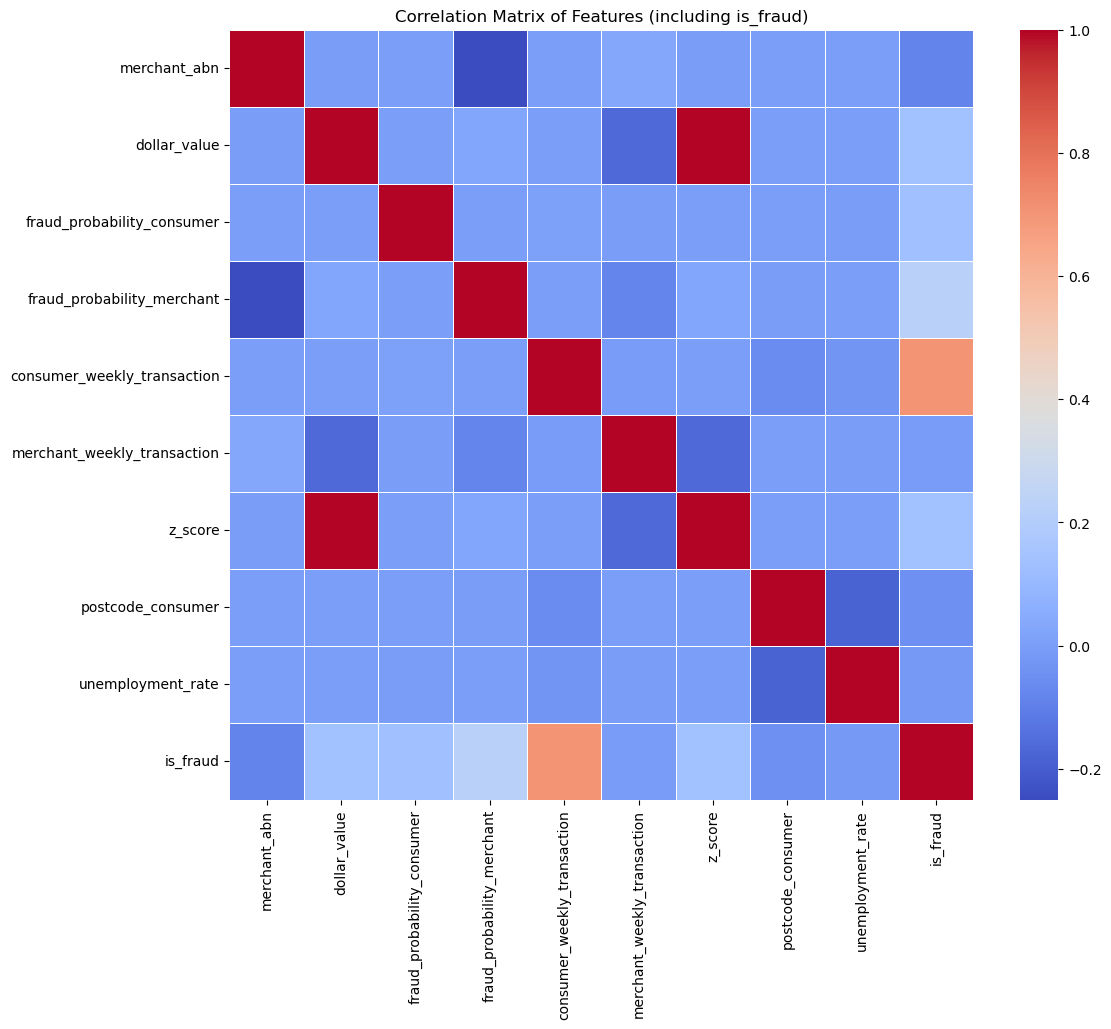

Correlation with 'is_fraud':
is_fraud                       1.000000
consumer_weekly_transaction    0.705600
fraud_probability_merchant     0.219207
dollar_value                   0.136579
z_score                        0.136579
fraud_probability_consumer     0.132166
merchant_weekly_transaction   -0.006004
unemployment_rate             -0.017846
postcode_consumer             -0.048817
merchant_abn                  -0.088656
Name: is_fraud, dtype: float64


In [14]:
pandas_df['unemployment_rate'] = pd.to_numeric(pandas_df['unemployment_rate'], errors='coerce')

numeric_columns = pandas_df.select_dtypes(include='number')

corr_matrix = pandas_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features (including is_fraud)')
plt.show()

correlation_with_target = pandas_df.corr()['is_fraud'].sort_values(ascending=False)

print("Correlation with 'is_fraud':")
print(correlation_with_target)

## Cross-Validation

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = pandas_df[["consumer_weekly_transaction", "fraud_probability_merchant", "dollar_value"]]
y = pandas_df["is_fraud"]

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_dev_scaled = scaler.transform(X_dev)

## XGBoost model

In [16]:
import xgboost as xgb
from sklearn import metrics

xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)

xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_dev_scaled)

print("\nXGBoost Accuracy:", metrics.accuracy_score(y_dev, y_pred_xgb))
print("Confusion Matrix for XGBoost:\n", metrics.confusion_matrix(y_dev, y_pred_xgb))
print("Classification Report for XGBoost:\n", metrics.classification_report(y_dev, y_pred_xgb))

y_pred_proba_xgb = xgb_model.predict_proba(X_dev_scaled)[:, 1]
roc_auc_xgb = metrics.roc_auc_score(y_dev, y_pred_proba_xgb)
print("ROC AUC Score for XGBoost:", roc_auc_xgb)


XGBoost Accuracy: 0.9307972029777123
Confusion Matrix for XGBoost:
 [[2787027  198030]
 [  80788  963154]]
Classification Report for XGBoost:
               precision    recall  f1-score   support

       False       0.97      0.93      0.95   2985057
        True       0.83      0.92      0.87   1043942

    accuracy                           0.93   4028999
   macro avg       0.90      0.93      0.91   4028999
weighted avg       0.93      0.93      0.93   4028999

ROC AUC Score for XGBoost: 0.9700055821407784


## Top 100 merchants

In [17]:
X_dev['merchant_abn'] = pandas_df['merchant_abn'].iloc[X_dev.index].values
X_dev['fraud_probability_xgb'] = y_pred_proba_xgb

top_merchants_aggregated = X_dev.groupby('merchant_abn')['fraud_probability_xgb'].min().reset_index()

top_100_merchants_xgb = top_merchants_aggregated.sort_values(by="fraud_probability_xgb", ascending=True).head(100)

print("Top 100 merchants predicted by XGBoost:")
print(top_100_merchants_xgb)

top_100_merchants_xgb.to_csv('../data/curated/top_100_merchants_xgb.csv', index=False)

Top 100 merchants predicted by XGBoost:
      merchant_abn  fraud_probability_xgb
1284   37459245212               0.000208
1719   46804135891               0.000214
333    17324645993               0.000227
1381   39896913161               0.000248
2493   64203420245               0.000248
...            ...                    ...
1235   36125151647               0.000338
1004   31585975447               0.000338
1694   46352584904               0.000338
2214   57900494384               0.000340
2960   74046727484               0.000340

[100 rows x 2 columns]
